In [388]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fcmeans import FCM 
#sklearn imports
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

df = pd.read_csv("Klebsiella_Meropenem_AMR_Genomics.csv")

print(df.head())
print(df.tail())
print(df.info())

   Genome ID  AAC(3)-IId  AAC(3)-IIe  AAC(3)-IV  AAC(3)-Ia  AAC(6')-29a  \
0  573.13031           0           1          0          0            0   
1  573.13032           0           1          0          0            0   
2  573.13033           0           1          0          0            0   
3  573.13034           0           0          0          0            0   
4  573.13035           0           1          0          0            0   

   AAC(6')-33  AAC(6')-IIa  AAC(6')-IIc  AAC(6')-Ib-cr  ...  Testing Standard  \
0           0            0            0              1  ...              CLSI   
1           0            0            0              1  ...              CLSI   
2           0            0            0              0  ...              CLSI   
3           0            0            0              0  ...              CLSI   
4           0            0            0              0  ...              CLSI   

   Testing Standard Year  Computational Method  Computational 

In [390]:
summary_stats = df.describe()
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
           Genome ID   AAC(3)-IId   AAC(3)-IIe    AAC(3)-IV    AAC(3)-Ia  \
count   1580.000000  1580.000000  1580.000000  1580.000000  1580.000000   
mean    5483.357047     0.035443     0.333544     0.036076     0.001266   
std    18133.369738     0.184955     0.471628     0.186538     0.035567   
min      573.130310     0.000000     0.000000     0.000000     0.000000   
25%      573.135517     0.000000     0.000000     0.000000     0.000000   
50%      573.140000     0.000000     0.000000     0.000000     0.000000   
75%      573.144593     0.000000     1.000000     0.000000     0.000000   
max    72407.698000     1.000000     1.000000     1.000000     1.000000   

       AAC(6')-29a   AAC(6')-33  AAC(6')-IIa  AAC(6')-IIc  AAC(6')-Ib-cr  ...  \
count  1580.000000  1580.000000  1580.000000  1580.000000    1580.000000  ...   
mean      0.000633     0.000633     0.001266     0.001899       0.255063  ...   
std       0.025158     0.025158     0.035567     0.043547   

In [392]:
# Check for missing values before
print("Missing values per column:\n", df.isnull().sum())

# Replace inf/-inf with NaN and check again
df.replace([np.inf, -np.inf], np.nan, inplace=True)
print("Missing values per column (after replacing inf):\n", df.isnull().sum())

Missing values per column:
 Genome ID                 0
AAC(3)-IId                0
AAC(3)-IIe                0
AAC(3)-IV                 0
AAC(3)-Ia                 0
                       ... 
Evidence                  0
Source                 1580
PubMed                  171
SEQUENCE                  0
Resistant Phenotype       0
Length: 302, dtype: int64
Missing values per column (after replacing inf):
 Genome ID                 0
AAC(3)-IId                0
AAC(3)-IIe                0
AAC(3)-IV                 0
AAC(3)-Ia                 0
                       ... 
Evidence                  0
Source                 1580
PubMed                  171
SEQUENCE                  0
Resistant Phenotype       0
Length: 302, dtype: int64


In [398]:
# Fill missing values in numeric columns with column means
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mean())

# Fill missing values in categorical columns with a placeholder
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna("Unknown", inplace=True)
    
# Encode categorical columns using LabelEncoder
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])
    print(f"Encoding column: {col}")

# Check for constant columns (zero variance) and drop them
zero_variance_columns = df.var()[df.var() == 0].index
df.drop(columns=zero_variance_columns, inplace=True)
print("Zero variance columns:", zero_variance_columns)

numerical_data = df.select_dtypes(include=[np.number])

# Fill any remaining NaNs with 0 as a fallback
numerical_data.fillna(0, inplace=True)

# Verify no missing values remain
print("Missing values per column AFTER cleaning:\n", df.isnull().sum())

Zero variance columns: Index([], dtype='object')
Missing values per column AFTER cleaning:
 Genome ID                              0
AAC(3)-IId                             0
AAC(3)-IIe                             0
AAC(3)-IV                              0
AAC(3)-Ia                              0
                                    ... 
Computational Method Performance    1580
Source                              1580
PubMed                                 0
SEQUENCE                               0
Resistant Phenotype                    0
Length: 286, dtype: int64


In [400]:
print("Checking for NaN in numerical data:", numerical_data.isnull().sum().sum())

Checking for NaN in numerical data: 0


In [402]:
# Encode resistance phenotype as binary (0: susceptible, 1: resistant)
df['Resistant Phenotype'] = df['Resistant Phenotype'].map({'susceptible': 0, 'resistant': 1})

X = df.drop(columns=['Resistant Phenotype'])
y = df['Resistant Phenotype']

In [408]:
# Specific columns of interest for ratio computation
columns_of_interest = numerical_data.columns[:2]  
derived_features = {}

# Create ratios only for pairs within columns of interest
for i, col1 in enumerate(columns_of_interest):
    for col2 in columns_of_interest[i + 1:]:  
        ratio_key = f"{col1}_to_{col2}_ratio"
        inverse_ratio_key = f"{col2}_to_{col1}_ratio"
        derived_features[ratio_key] = numerical_data[col1] / (numerical_data[col2] + 1e-8)
        derived_features[inverse_ratio_key] = numerical_data[col2] / (numerical_data[col1] + 1e-8)

# Convert derived features dictionary to DataFrame
derived_features_df = pd.DataFrame(derived_features)

batch_size = 500  
batches = [derived_features_df.iloc[:, i:i + batch_size] for i in range(0, derived_features_df.shape[1], batch_size)]

for batch in batches:
    numerical_data = pd.concat([numerical_data, batch], axis=1)
print("Numerical data shape after adding derived features:", numerical_data.shape)


Numerical data shape after adding derived features: (1580, 290)


In [410]:
# Correlation matrix
correlation_matrix = pd.DataFrame(scaled_data, columns=numerical_data.columns).corr()
print(correlation_matrix['Resistant Phenotype'])

Genome ID                       NaN
AAC(3)-IId                      NaN
AAC(3)-IIe                      NaN
AAC(3)-IV                       NaN
AAC(3)-Ia                       NaN
                                 ..
Resistant Phenotype             NaN
Genome ID_to_AAC(3)-IId_ratio   NaN
AAC(3)-IId_to_Genome ID_ratio   NaN
Genome ID_to_AAC(3)-IId_ratio   NaN
AAC(3)-IId_to_Genome ID_ratio   NaN
Name: Resistant Phenotype, Length: 290, dtype: float64


In [412]:
# MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numerical_data)
scaled_data = np.nan_to_num(scaled_data, nan=0.0, posinf=0.0, neginf=0.0)

# Verify no invalid values after scaling
print("Checking for NaN in scaled data:", np.isnan(scaled_data).sum())
print("Checking for inf in scaled data:", np.isinf(scaled_data).sum())

print("Data scaled successfully!")
print("Scaled data shape:", scaled_data.shape)
print("First 5 rows of scaled data:\n", scaled_data[:5])


Checking for NaN in scaled data: 0
Checking for inf in scaled data: 0
Data scaled successfully!
Scaled data shape: (1580, 290)
First 5 rows of scaled data:
 [[0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  7.91532282e-03 0.00000000e+00]
 [1.39208743e-10 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  7.91532296e-03 0.00000000e+00]
 [2.78417489e-10 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  7.91532310e-03 0.00000000e+00]
 [4.17626234e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.91532323e-03 0.00000000e+00]
 [5.56834979e-10 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  7.91532337e-03 0.00000000e+00]]


In [414]:
# PCA
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(scaled_data)
explained_variance_ratio_pca = pca.explained_variance_ratio_
print("PCA completed!")
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("First 5 rows of PCA result:\n", pca_result[:5])

PCA completed!
Explained variance ratio: [0.20280004 0.12627516]
First 5 rows of PCA result:
 [[ 1.69688449 -0.92226622]
 [ 1.716043   -0.94153326]
 [ 0.22702997 -1.2046365 ]
 [-1.97483507  0.94567668]
 [ 0.22173022 -1.21530754]]


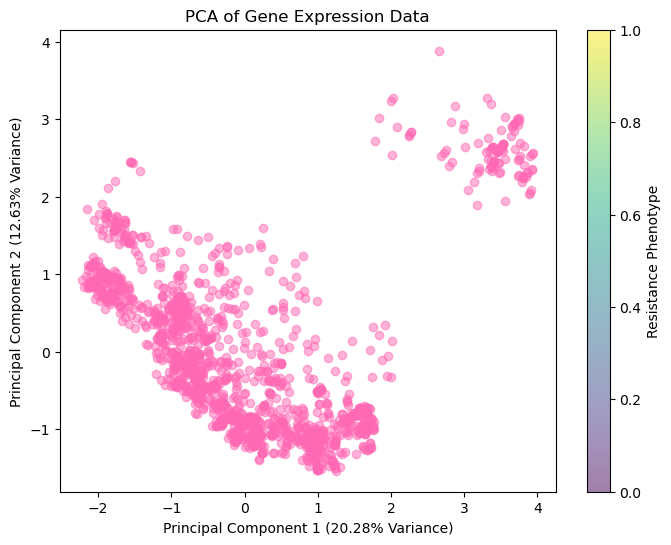

In [416]:
# Visualization: PCA Scatter Plot and Resistance Phenotype scale
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='hotpink',  alpha=0.5)
plt.title('PCA of Gene Expression Data')
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio_pca[0]*100:.2f}% Variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio_pca[1]*100:.2f}% Variance)')
plt.colorbar(label='Resistance Phenotype')
plt.show()

In [418]:
# SVD
svd = TruncatedSVD(n_components=2)  
svd_result = svd.fit_transform(scaled_data)
explained_variance_ratio_svd = svd.explained_variance_ratio_
print("SVD completed!")
print("Explained variance ratio:", svd.explained_variance_ratio_)
print("First 5 rows of SVD result:\n", svd_result[:5])

SVD completed!
Explained variance ratio: [0.01078667 0.20280004]
First 5 rows of SVD result:
 [[ 5.20357362  1.69698367]
 [ 5.4183385   1.71617805]
 [ 5.02709805  0.22707564]
 [ 5.0701265  -1.97482215]
 [ 5.00971093  0.22177343]]


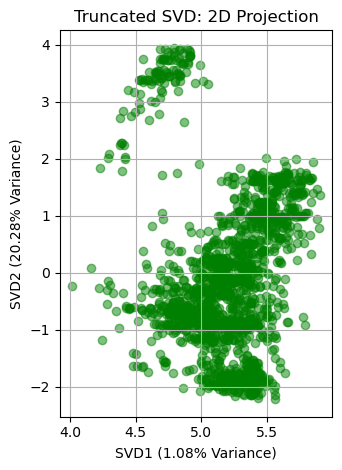

In [420]:
# Visualization: Truncated SVD Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(svd_result[:, 0], svd_result[:, 1], c='green', alpha=0.5)
plt.title("Truncated SVD: 2D Projection")
plt.xlabel(f"SVD1 ({explained_variance_ratio_svd[0]*100:.2f}% Variance)")
plt.ylabel(f"SVD2 ({explained_variance_ratio_svd[1]*100:.2f}% Variance)")
plt.grid()
plt.tight_layout()
plt.show()

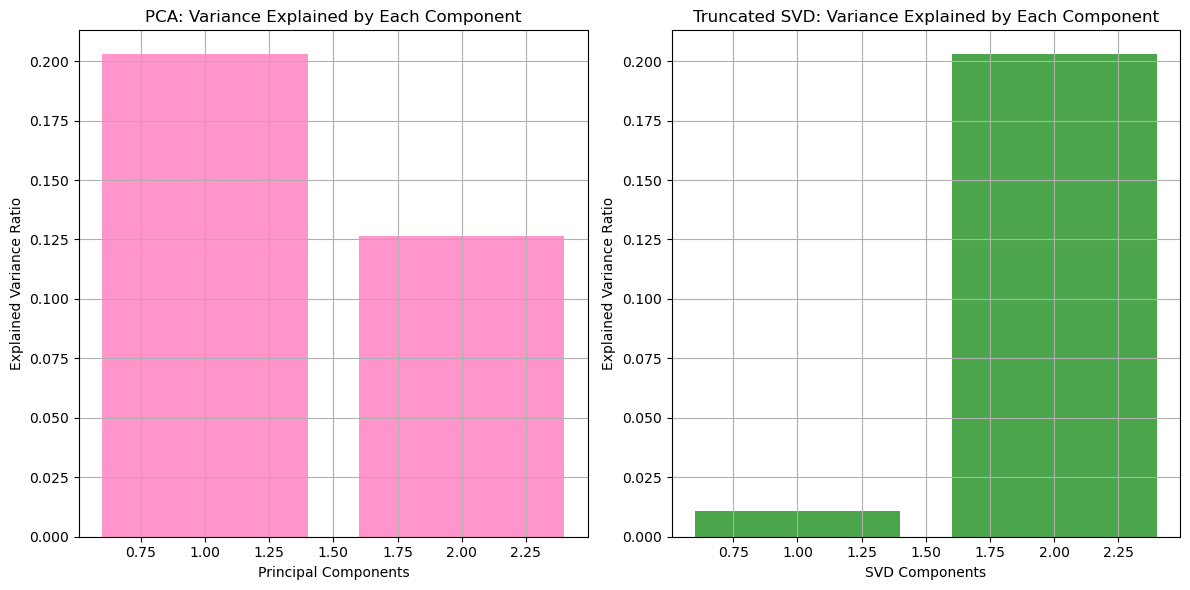

In [422]:
# Variance Explained Bar Plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio_pca) + 1), explained_variance_ratio_pca, alpha=0.7, color='hotpink')
plt.title("PCA: Variance Explained by Each Component")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.subplot(1, 2, 2)
plt.bar(range(1, len(explained_variance_ratio_svd) + 1), explained_variance_ratio_svd, alpha=0.7, color='green')
plt.title("Truncated SVD: Variance Explained by Each Component")
plt.xlabel("SVD Components")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.tight_layout()
plt.show()

In [424]:
# Function to plot clusters
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels, palette="viridis", s=50, legend='full')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster")
    plt.show()

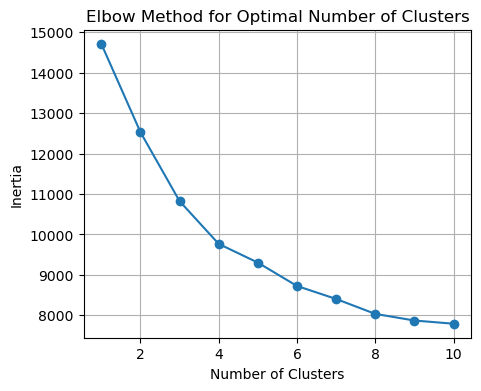

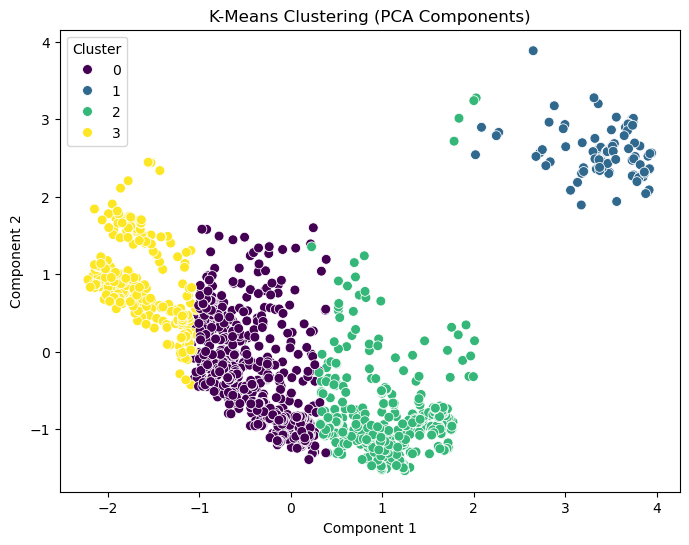

In [426]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["OMP_NUM_THREADS"] = '7'
# 1. K-Means Clustering (Using Elbow Method)
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()
# Visualize K-means results using PCA Components
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(svd_result)
plot_clusters(pca_result, kmeans_labels, "K-Means Clustering (PCA Components)")

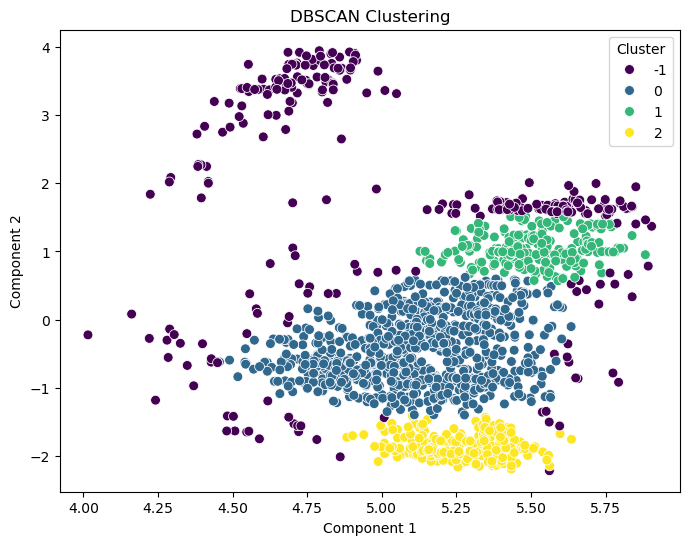

In [428]:
# 2. DBSCAN Clustering
dbscan = DBSCAN(eps=0.3, min_samples=150)
dbscan_labels = dbscan.fit_predict(svd_result)
plot_clusters(svd_result, dbscan_labels, "DBSCAN Clustering")

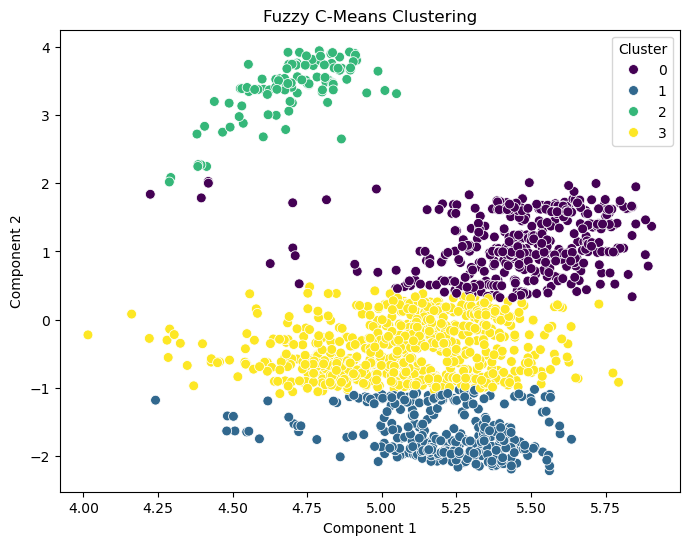

In [430]:
# 3. Fuzzy C-Means Clustering
fcm = FCM(n_clusters=4)
fcm.fit(svd_result)
fcm_labels = fcm.predict(svd_result)
plot_clusters(svd_result, fcm_labels, "Fuzzy C-Means Clustering")

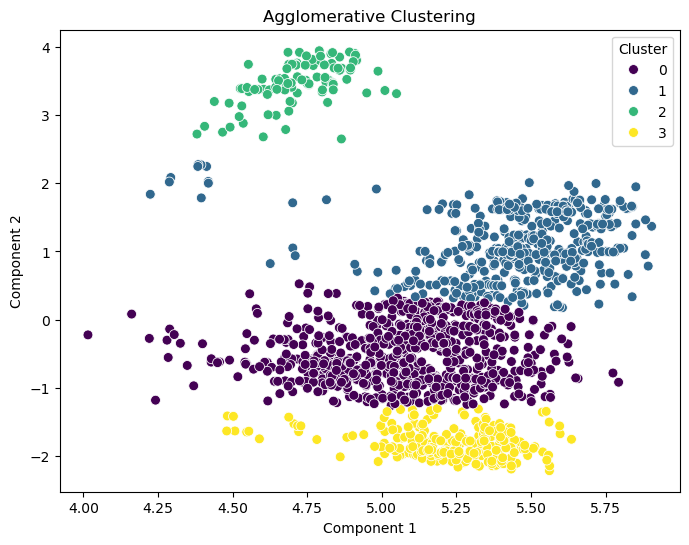

In [432]:
# 4. Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4, linkage='ward')
agglo_labels = agglo.fit_predict(svd_result)
plot_clusters(svd_result, agglo_labels, "Agglomerative Clustering")

In [434]:
print("Cluster Counts:")
print("K-Means:", np.bincount(kmeans_labels))
print("DBSCAN:", np.bincount(dbscan_labels + 1))
print("Fuzzy C-Means:", np.bincount(fcm_labels))
print("Agglomerative:", np.bincount(agglo_labels))

Cluster Counts:
K-Means: [716 104 443 317]
DBSCAN: [293 832 239 216]
Fuzzy C-Means: [433 318 104 725]
Agglomerative: [777 458  98 247]


In [468]:
target = numerical_data.columns[0]  
X = numerical_data.drop(columns=['Resistant Phenotype'])
y = numerical_data['Resistant Phenotype']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [472]:
# logistic regression model
logreg = LogisticRegression()

logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00       211

    accuracy                           1.00       316
   macro avg       1.00      1.00      1.00       316
weighted avg       1.00      1.00      1.00       316

Confusion Matrix:
 [[105   0]
 [  0 211]]


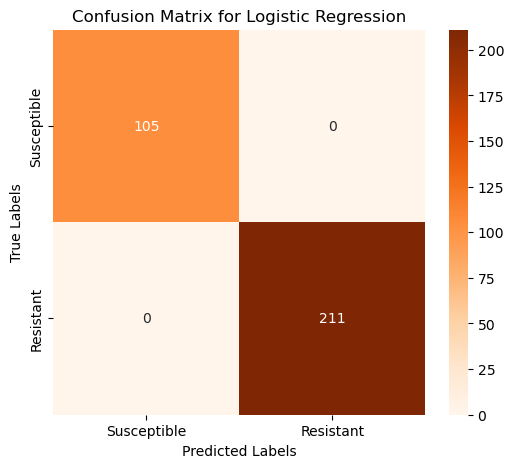

In [474]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=['Susceptible', 'Resistant'], yticklabels=['Susceptible', 'Resistant'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [476]:
scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5)
print("Cross-validation scores:", scores)

Cross-validation scores: [0.99604743 0.99604743 0.99209486 1.         0.99603175]


In [478]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


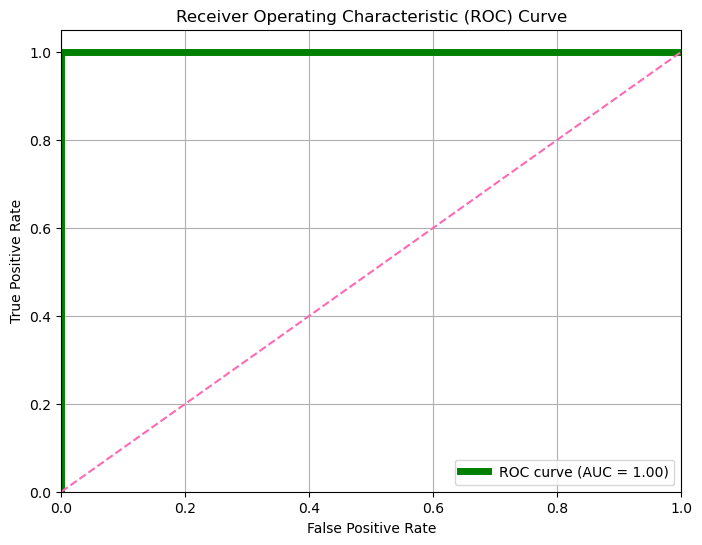

In [462]:
# Predicted probabilities for the test set 
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]  

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=5, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='hotpink', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Top 10 most important genes based on L1-regularized Logistic Regression:
                    Gene  Importance
272     Measurement Sign    6.549432
258          Host Gender    1.731407
252    Isolation Country    0.685402
47                 KPC-1    0.670267
254  Geographic Location    0.577616
83                QnrB17    0.354275
168               dfrA30    0.165571
186               tet(A)    0.151465
31               CTX-M-2    0.138176
101               SHV-12    0.057651


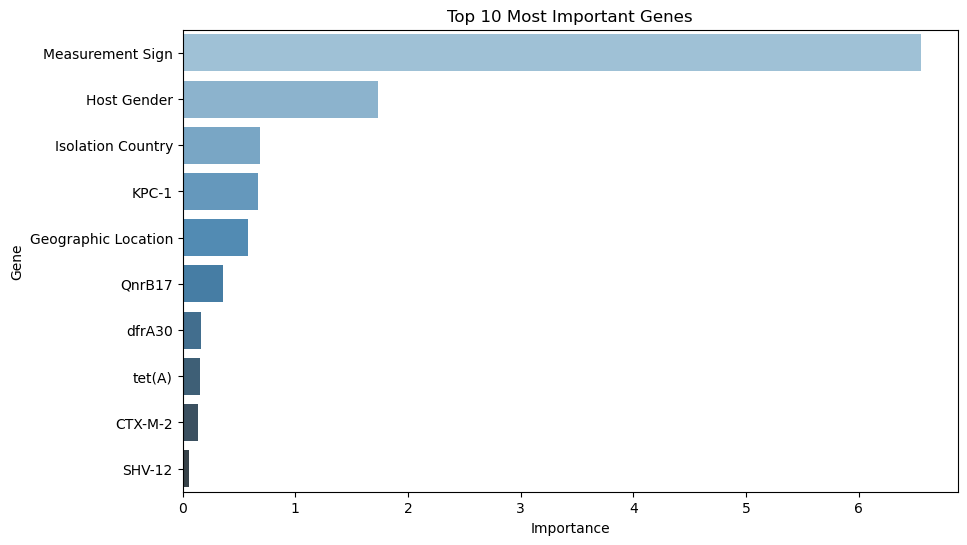

In [480]:
#logistic regression model with L1 regularization (Lasso)
logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

logreg.fit(X_train_scaled, y_train)

importance = np.abs(logreg.coef_[0])

importance_df = pd.DataFrame({
    'Gene': X.columns,
    'Importance': importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top 10 most important genes based on L1-regularized Logistic Regression:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Gene', data=importance_df.head(10), palette="Blues_d")
plt.title("Top 10 Most Important Genes")
plt.xlabel('Importance')
plt.ylabel('Gene')
plt.show()


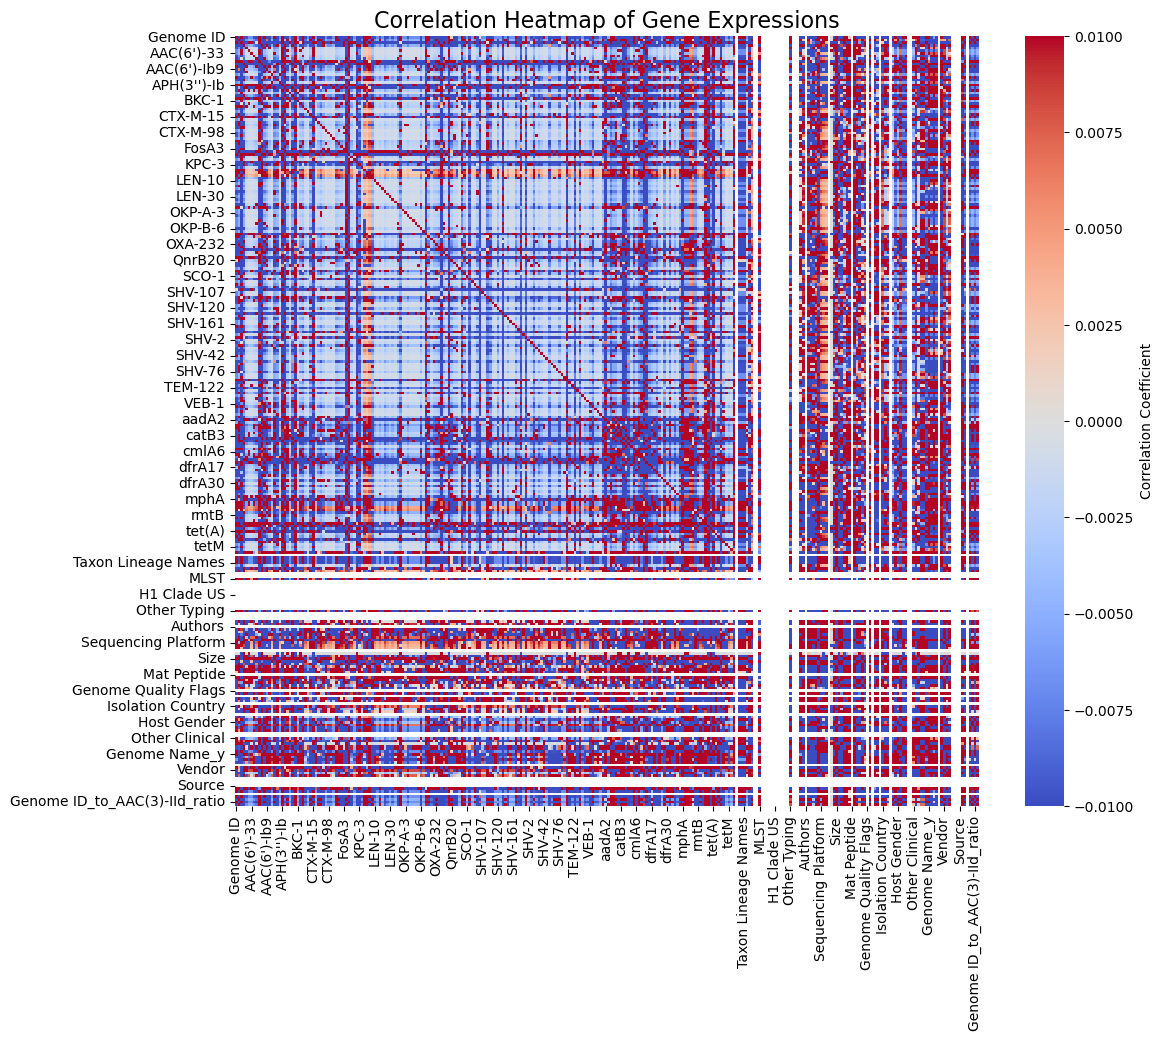

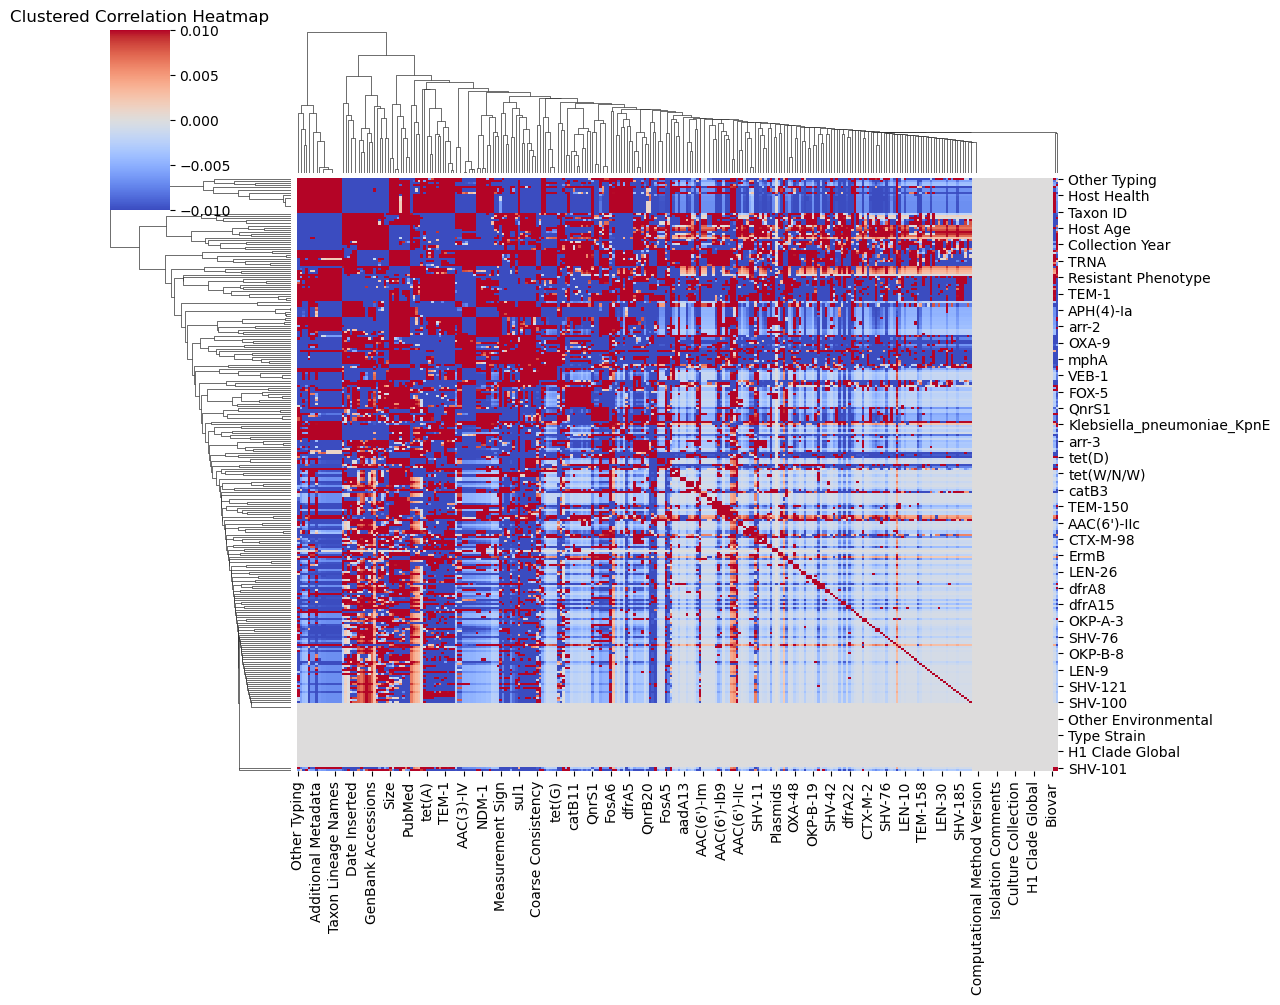

In [482]:
plt.figure(figsize=(12, 10))  
sns.heatmap(
    correlation_matrix,
    annot=False,  
    cmap='coolwarm',  
    fmt='.2f',
    vmin=-0.01, vmax=0.01,  
    cbar_kws={'label': 'Correlation Coefficient'},  
)

plt.title('Correlation Heatmap of Gene Expressions', fontsize=16)
plt.show()

corr_matrix = corr_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)

# Clustered heatmap
sns.clustermap(
    corr_matrix,
    cmap='coolwarm',     
    figsize=(12, 10),     
    vmin=-.01, vmax=.01,      
    method='average',     
    metric='euclidean',   
    annot=False          
)
plt.title('Clustered Correlation Heatmap')
plt.show()

